In [ ]:
#1 importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sns.set(style="whitegrid")

In [ ]:
#2 ahora las nominas
df1 = pd.read_excel("./data/acuario.xlsx")
df2 = pd.read_excel("./data/ciencia.xlsx")
df3 = pd.read_excel("./data/comedores.xlsx")
df4 = pd.read_excel("./data/consumidor.xlsx")
df5 = pd.read_excel("./data/contraloria.xlsx")

In [ ]:
#3 Homogeneizar columnas
def clean_cols(df):
    df.columns = (
        df.columns
        .str.lower()
        .str.strip()
        .str.replace(" ", "_")
        .str.replace("-", "_")
    )
    return df

df1 = clean_cols(df1)
df2 = clean_cols(df2)
df3 = clean_cols(df3)
df4 = clean_cols(df4)
df5 = clean_cols(df5)

In [ ]:
#4 Concatenar las nominas en una sola
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df

In [ ]:
#fase 2 - limpieza de datos
#5 Revisar datos nulos y calidad
df.isnull().sum()

In [ ]:
#6 Eliminar filas vacias
df = df.dropna(how="all")

In [7]:
#7 Limpiar columna de sueldo
df = df.copy() 
temp = (
    df["sueldo_bruto"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.replace(" ", "", regex=False)
)

temp = pd.to_numeric(temp, errors="coerce")
df.loc[:, "sueldo_bruto"] = temp

In [ ]:
#fase 2 - limpieza de datos
df.isnull().sum()

nombres         0
apellidos       0
insitución      0
función         0
área            0
genero          0
estatus         0
sueldo_bruto    0
dtype: int64

In [ ]:
#7. Eliminar filas vacias
df = df.dropna(how="all")

In [ ]:
#8. Revisar tipos de datos
df.dtypes

nombres         object
apellidos       object
insitución      object
función         object
área            object
genero          object
estatus         object
sueldo_bruto    object
dtype: object

In [ ]:
#10. Identificar columnas categóricas
df.select_dtypes(include="object").columns

Index(['nombres', 'apellidos', 'insitución', 'función', 'área', 'genero',
       'estatus', 'sueldo_bruto'],
      dtype='object')

In [ ]:
#12. Verificar que tenemos minimo 6 features + 1 label
df.shape

(6052, 8)

In [ ]:
#FASE 3 — ANÁLISIS EXPLORATORIO (EDA)
#13. Estadisticas basicas
df.describe()

,nombres,apellidos,insitución,función,área,genero,estatus,sueldo_bruto
count,6052,6052,6052,6052,6052,6052,6052,6052.0
unique,4434,5048,5,402,307,2,6,146.0
top,JOSE LUIS,FELIZ FELIZ,COMEDORES ECONOMICOS DEL ESTADO,CONSERJE,DIRECCIÓN DE UNIDADES DE AUDITORÍA INTERNA GUB...,FEMENINO,FIJO,13000.0
freq,22,19,2600,501,889,3191,4187,1192.0


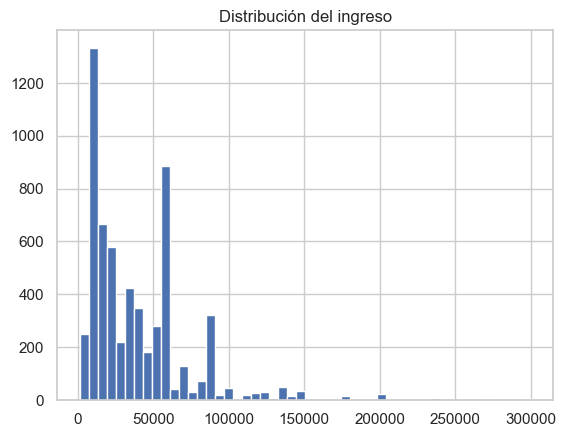

In [ ]:
#14 Histograma del ingreso
plt.hist(df["sueldo_bruto"], bins=50)
plt.title("Distribución del ingreso")
plt.show()

<Axes: xlabel='genero', ylabel='sueldo_bruto'>

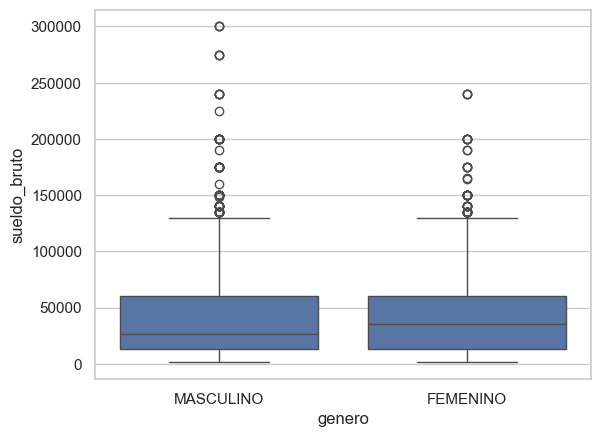

In [ ]:
#15. Boxplot por género
sns.boxplot(x="genero", y="sueldo_bruto", data=df)

<Axes: >

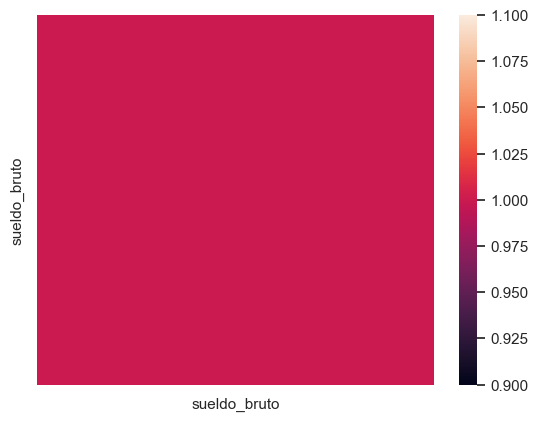

In [ ]:
#16. Correlaciones
df["sueldo_bruto"] = pd.to_numeric(df["sueldo_bruto"], errors="coerce")
df = df.dropna(subset=["sueldo_bruto"])

sns.heatmap(df.select_dtypes(include="number").corr())

In [ ]:
#17. Ingreso por institución
df.groupby("insitución")["sueldo_bruto"].mean().sort_values()

insitución
COMEDORES ECONOMICOS DEL ESTADO                                    17366.176454
INSTITUTO NACIONAL DE PROTECCION DE LOS DERECHOS DEL CONSUMIDOR    43321.351748
ACUARIO NACIONAL                                                   44865.404040
MINISTERIO DE EDUCACION SUPERIOR, CIENCIA Y TECNOLOGIA             51700.894854
CONTRALORIA GENERAL DE LA REPUBLICA                                62390.426340
Name: sueldo_bruto, dtype: float64

In [ ]:
#FASE 4 — MODELOS DE REGRESIÓN
#18. Dividir X e y
X = df.drop("sueldo_bruto", axis=1)
y = df["sueldo_bruto"]
X.head(), y.head()
print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

Shape de X: (6052, 7)
Shape de y: (6052,)


In [ ]:
#19. Train-test split
X = df[["insitución", "función", "área", "genero", "estatus"]]
y = df["sueldo_bruto"]

# --- Train-Test Split ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (4841, 5)
X_test: (1211, 5)
y_train: (4841,)
y_test: (1211,)


In [20]:
#20 Codificar variables categoricas
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

cat_cols = X.columns 
num_cols = []          
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder="drop"
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4841, 674)
X_test shape: (1211, 674)
y_train shape: (4841,)
y_test shape: (1211,)


In [21]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

modelos = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Bayesian": BayesianRidge(),
    "KNN": KNeighborsRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    #"SVR": SVR(),
    "MLP": MLPRegressor(max_iter=500),
    "AdaBoost": AdaBoostRegressor()
}

resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    pred = modelo.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    resultados.append([nombre, mse, np.sqrt(mse), r2])

import pandas as pd
tabla = pd.DataFrame(resultados, columns=["Modelo","MSE","RMSE","R2"])
tabla

C:\Users\Alb3rtsonTL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e+10, tolerance: 5.282e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Alb3rtsonTL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Modelo,MSE,RMSE,R2
0,OLS,7.058904e+34,2.656860e+17,-6.517837e+25
1,Ridge,2.479317e+08,1.574585e+04,7.710723e-01
2,Lasso,2.479964e+08,1.574790e+04,7.710126e-01
3,Bayesian,2.501883e+08,1.581734e+04,7.689887e-01
4,KNN,3.878123e+08,1.969295e+04,6.419136e-01
5,DecisionTree,3.408163e+08,1.846121e+04,6.853073e-01
6,RandomForest,2.312773e+08,1.520780e+04,7.864501e-01
7,MLP,2.939491e+08,1.714494e+04,7.285822e-01
8,AdaBoost,8.083900e+08,2.843220e+04,2.535733e-01



RESULTADOS DE EVALUACIÓN

Tabla de Métricas Completa:
      Modelo          MSE         RMSE            R2
         OLS 7.058904e+34 2.656860e+17 -6.517837e+25
       Ridge 2.479317e+08 1.574585e+04  7.710723e-01
       Lasso 2.479964e+08 1.574790e+04  7.710126e-01
    Bayesian 2.501883e+08 1.581734e+04  7.689887e-01
         KNN 3.878123e+08 1.969295e+04  6.419136e-01
DecisionTree 3.408163e+08 1.846121e+04  6.853073e-01
RandomForest 2.312773e+08 1.520780e+04  7.864501e-01
         MLP 2.939491e+08 1.714494e+04  7.285822e-01
    AdaBoost 8.083900e+08 2.843220e+04  2.535733e-01

MEJOR MODELO: RandomForest
   R² en Test: 0.7865


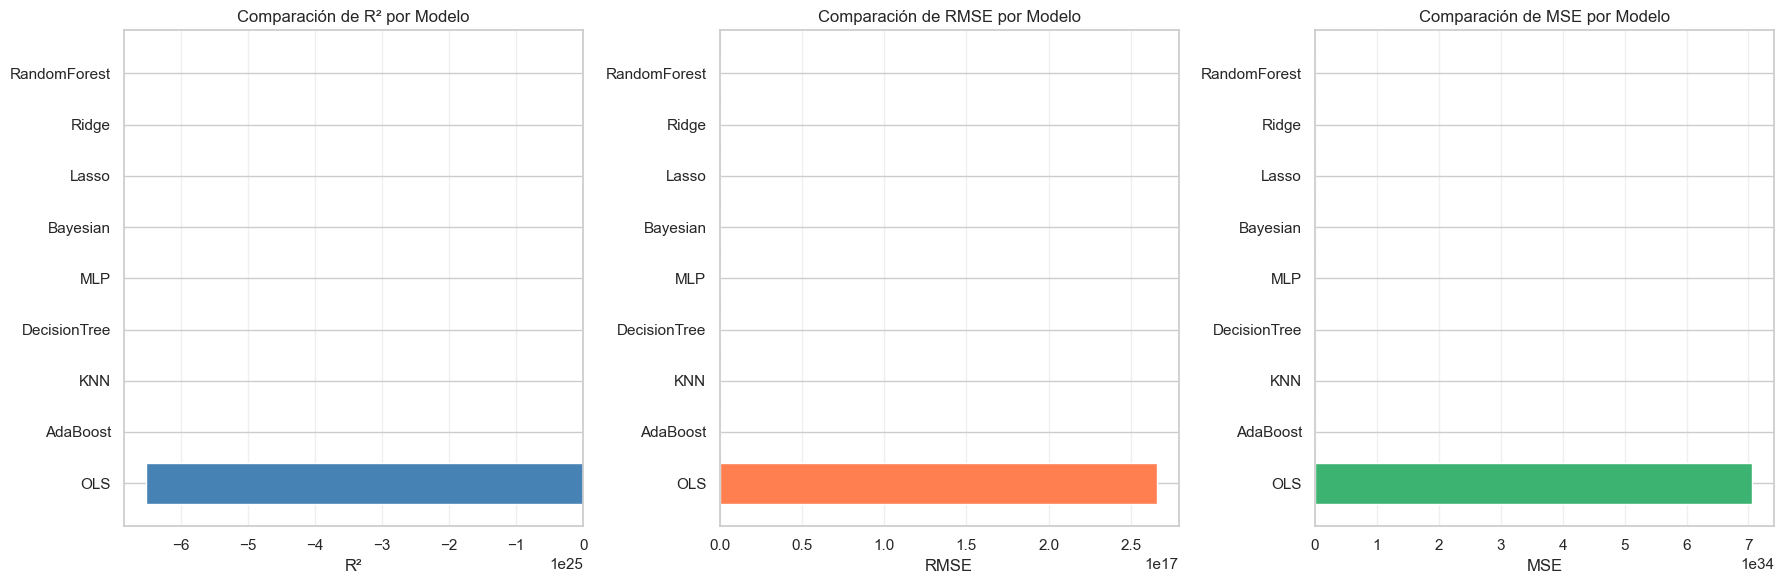

In [22]:
df_resultados = tabla  # renombramos para mantener consistencia

print("\n" + "="*60)
print("RESULTADOS DE EVALUACIÓN")
print("="*60)
print("\nTabla de Métricas Completa:")
print(df_resultados.to_string(index=False))

# Mejor modelo según R²
mejor_modelo_idx = df_resultados['R2'].idxmax()
mejor_modelo_nombre = df_resultados.loc[mejor_modelo_idx, 'Modelo']
mejor_r2 = df_resultados.loc[mejor_modelo_idx, 'R2']

print(f"\nMEJOR MODELO: {mejor_modelo_nombre}")
print(f"   R² en Test: {mejor_r2:.4f}")

# Visualización de resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Comparación de R²
df_sorted = df_resultados.sort_values('R2', ascending=True)
axes[0].barh(df_sorted['Modelo'], df_sorted['R2'], color='steelblue')
axes[0].set_xlabel('R²')
axes[0].set_title('Comparación de R² por Modelo')
axes[0].grid(True, alpha=0.3, axis='x')

# 2. Comparación de RMSE
axes[1].barh(df_sorted['Modelo'], df_sorted['RMSE'], color='coral')
axes[1].set_xlabel('RMSE')
axes[1].set_title('Comparación de RMSE por Modelo')
axes[1].grid(True, alpha=0.3, axis='x')

# 3. Comparación de MSE
axes[2].barh(df_sorted['Modelo'], df_sorted['MSE'], color='mediumseagreen')
axes[2].set_xlabel('MSE')
axes[2].set_title('Comparación de MSE por Modelo')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [23]:
# 1. Cargar el CSV nuevo
nuevo = pd.read_csv("nuevo.csv", encoding="latin1", sep="\t")

# 2. Guardar paquete correctamente
paquete = {
    "model": modelo_final,
    "preprocessor": preprocessor,
    "scaler": scaler
}

# 3. Cargar paquete
paquete = joblib.load("AdaBoost.joblib")

modelo_final = paquete["model"]
preprocessor = paquete["preprocessor"]
scaler = paquete["scaler"]

# 4. Seleccionar columnas del nuevo CSV
cols = ["insitución", "función", "área", "genero", "estatus"]
nuevo = nuevo[cols]

# 5. Transformaciones
nuevo_ohe = preprocessor.transform(nuevo)
nuevo_scaled = scaler.transform(nuevo_ohe)

# 6. Predicción
prediccion = modelo_final.predict(nuevo_scaled)
prediccion

FileNotFoundError: [Errno 2] No such file or directory: 'nuevo.csv'